In [74]:
"""
This dataset could be used to train a 3D CNN with 3D inputs and 3D outputs / 3D ground truth
Note: This requires more memory and computiational power
"""

'\nThis dataset could be used to train a 3D CNN with 3D inputs and 3D outputs / 3D ground truth\nNote: This requires more memory and computiational power\n'

In [75]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

file_path = "test_data.hdf5"

with h5py.File(file_path, "r") as f:
    high_data = f["/high_count/data"][:]   # (192, 240, 3034)
    low_data = f["/low_count/data"][:]     # (192, 240, 3034)

# Transpose: Matlab --> Python
high_data = high_data.transpose(2, 0, 1)   # (3034, 192, 240)
low_data = low_data.transpose(2, 0, 1)     # (3034, 192, 240)

In [76]:
def anscombe_vst(x):
    # Negative values get yeeted to zero (counts should not be negative)
    x = np.maximum(x, 0)
    return 2.0 * np.sqrt(x + 3.0/8.0)

def compute_clip_from_high(high_data, percentile=99.9, use_vst=True, max_samples=5_000_000, rng=None):
    """
    From High count data, determine global Clip_values
    percentile: e.g. 99.9
    use_vst: If True -> Calculate Clip on VSC domain (usually better)
    """
    rng = np.random.default_rng() if rng is None else rng
    arr = high_data.ravel()

    if arr.size > max_samples:
        idx = rng.choice(arr.size, size=max_samples, replace=False)
        sample = arr[idx]
    else:
        sample = arr

    if use_vst:
        sample = anscombe_vst(sample) # Only for estimation of clip_val

    clip_val = np.percentile(sample, percentile)
    if not np.isfinite(clip_val) or clip_val <= 0:
        clip_val = float(np.max(sample))
    return float(clip_val)

def preprocess_counts(x, clip_val, use_vst=True, dtype=np.float32):
    """
    Normalization: optional VST -> clip -> /clip -> [0,1]
    """
    x = anscombe_vst(x) if use_vst else x
    x = np.clip(x, 0, clip_val) / clip_val
    return x.astype(dtype)

In [77]:
def build_sequential_dataset(low_data, high_data, size, group_len, dtype=np.float32):
    """
    Generates training data:
      X: (B, size, H, W) = window of `size` Low-Count images
      Y: (B, size, H, W) = Ground truth = window of `size` High-Count images (3D output)
    """
    assert low_data.shape == high_data.shape, "low/high must have identical shapes"
    N, H, W = low_data.shape

    if size % 2 == 0 or size < 1:
        raise ValueError("`size` must be odd and >= 1 (e.g., 3, 5, 7)")
    if N % group_len != 0:
        raise ValueError(f"N={N} is not a multiple of group_len={group_len}.")

    k = size // 2       # Index for middle of window
    num_groups = N // group_len

    X_list, Y_list = [], []

    for group_index in range(num_groups):
        start = group_index * group_len
        end   = start + group_len
        # slide window inside this block only
        for n in range(start, end - size + 1):
            seq_win    = low_data[n : n + size]   # (size, H, W)
            # CHANGED: Here we also take a window of high_data
            target_win = high_data[n : n + size]  # (size, H, W)
            X_list.append(seq_win)
            Y_list.append(target_win)

    X = np.stack(X_list, axis=0).astype(dtype)   # (B, size, H, W)
    Y = np.stack(Y_list, axis=0).astype(dtype)   # (B, size, H, W)
    # Adding Channel-Dimension
    X = X[:, None, ...]  # (B, 1, size, H, W)
    Y = Y[:, None, ...]  # (B, 1, size, H, W)
    return X, Y

# ===== Applying on loaded (N,H,W) data =====
size = 5 # Adjust to find best value (e.g. 3,5,7)
group_len = 41

# === Normalisierung ===
USE_VST = True
PCT = 99.9

clip_val = compute_clip_from_high(high_data, percentile=PCT, use_vst=USE_VST)

low_data_n  = preprocess_counts(low_data,  clip_val, use_vst=USE_VST)
high_data_n = preprocess_counts(high_data, clip_val, use_vst=USE_VST)

# 3D-Version
X, Y = build_sequential_dataset(low_data_n, high_data_n, size, group_len, dtype=np.float32)

print("X shape (B, C, size, H, W):", X.shape)  # C=1
print("Y shape (B, C, size, H, W):", Y.shape)

# ---- Sanity check for the first block ----
b0_start = 0

# erwartete Fenster: low_data_n[0:5] und high_data_n[0:5]
seq0 = X[0, 0]   # (size, H, W)  -> sollte low_data_n[0:size] sein
gt0  = Y[0, 0]   # (size, H, W)  -> sollte high_data_n[0:size] sein

# Comparing arrays
print("Seq == low_n[0:5]:",
      np.allclose(seq0, low_data_n[0:size], atol=1e-7))
print("GT  == high_n[0:5]:",
      np.allclose(gt0,  high_data_n[0:size], atol=1e-7))

X shape (B, C, size, H, W): (2738, 1, 5, 192, 240)
Y shape (B, C, size, H, W): (2738, 1, 5, 192, 240)
Seq == low_n[0:5]: True
GT  == high_n[0:5]: True


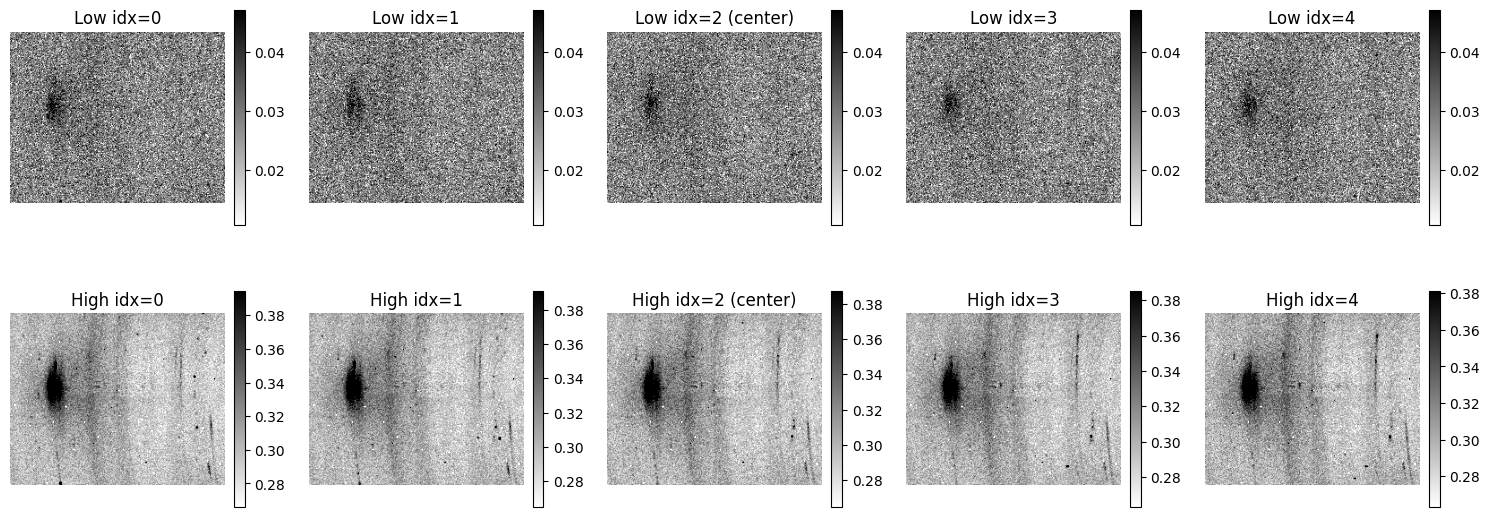

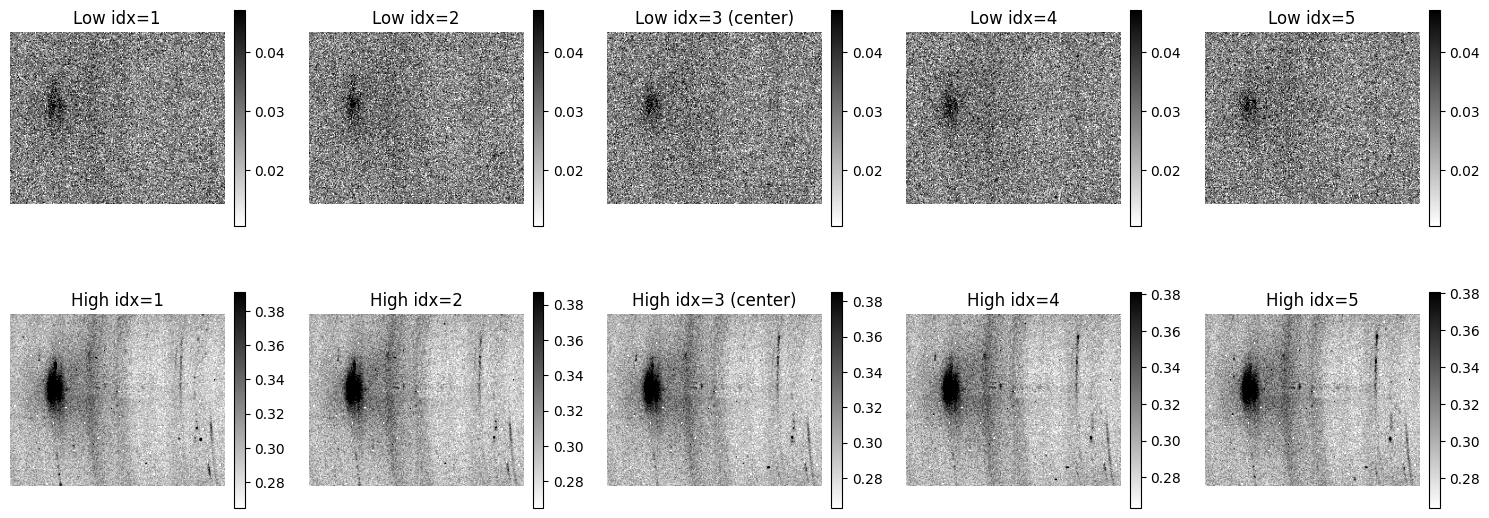

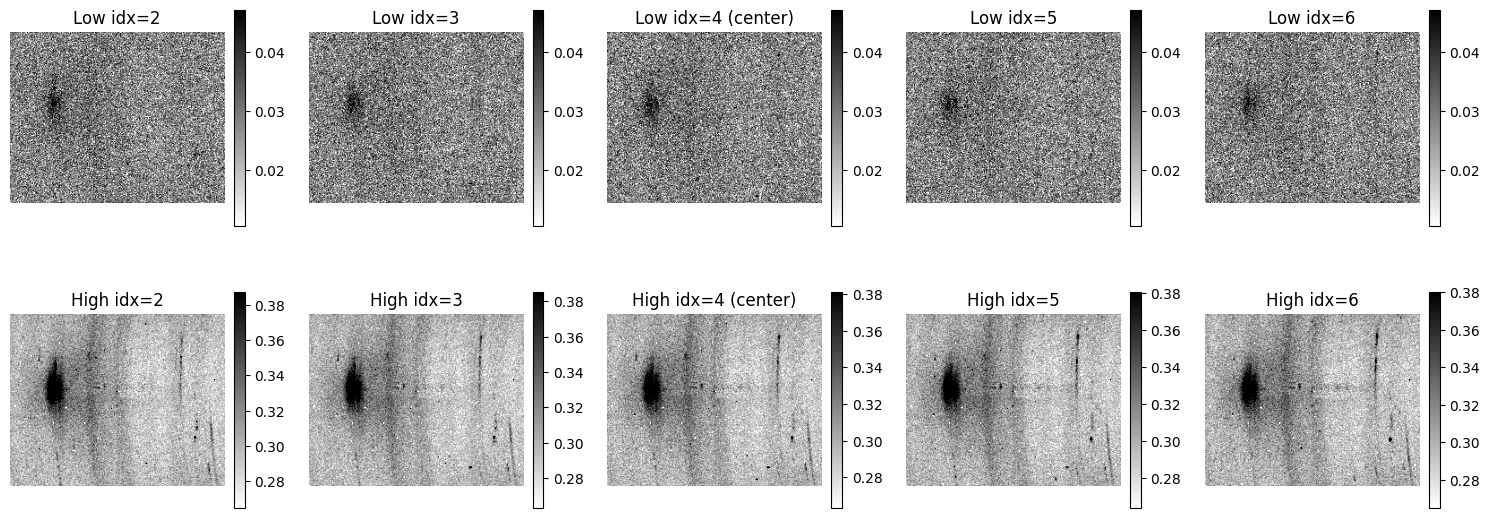

In [78]:
# ===== Visualization of some samples =====

def show_window_pair_3d(X, Y, sample_idx, size=5, group_len=41, share_scale=False):
    """
    Visualizes training sample for 3D:
      - Top: Low_Count sequence
      - Bottom: High_Count sequence

    X: (B, 1, size, H, W)  # Note: 1 is the number of channels (here 1)
    Y: (B, 1, size, H, W)
    """

    # Remove channel dimension
    seq_low = X[sample_idx]    # (1, size, H, W)
    seq_high = Y[sample_idx]   # (1, size, H, W)
    if seq_low.ndim == 4 and seq_low.shape[0] == 1:
        seq_low = seq_low[0]
        seq_high = seq_high[0]

    k = size // 2
    group_idx = sample_idx // (group_len - size + 1)
    offset_in_group = sample_idx % (group_len - size + 1)
    global_start = group_idx * group_len + offset_in_group
    frame_indices = list(range(global_start, global_start + size))

    fig, axes = plt.subplots(2, size, figsize=(3 * size, 6))

    for j in range(size):
        # Low-Count
        vmin, vmax = np.percentile(seq_low[j].ravel(), (1, 99))
        im_low = axes[0, j].imshow(
            seq_low[j], cmap="gray_r", origin="lower",
            aspect="equal", vmin=vmin, vmax=vmax
        )
        axes[0, j].set_title(f"Low idx={frame_indices[j]}")
        axes[0, j].axis("off")
        fig.colorbar(im_low, ax=axes[0, j], fraction=0.046, pad=0.04)

        # High-Count
        vmin, vmax = np.percentile(seq_high[j].ravel(), (1, 99))
        im_high = axes[1, j].imshow(
            seq_high[j], cmap="gray_r", origin="lower",
            aspect="equal", vmin=vmin, vmax=vmax
        )
        axes[1, j].set_title(f"High idx={frame_indices[j]}")
        axes[1, j].axis("off")
        fig.colorbar(im_high, ax=axes[1, j], fraction=0.046, pad=0.04)

    axes[0, k].set_title(f"Low idx={frame_indices[k]} (center)")
    axes[1, k].set_title(f"High idx={frame_indices[k]} (center)")

    plt.tight_layout()
    plt.show()


# Visualize some samples
for idx in range(0, 3):
    show_window_pair_3d(X, Y, sample_idx=idx, size=5, group_len=41)
